In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_theme(style='darkgrid')

import time

# import my utility methods for this project
import utils_practical_2 as my_utils

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# On to Modeling ...

**This notebook picks up from the Data Investigation (see ```DataInvestigation.ipynb```)**

[Local file](DataInvestigation.ipynb)
[Github](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_II/blob/main/DataInvestigation.ipynb)

## Data Cleanup

The data cleansing results are as follows:

In [5]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.13445091247558594
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformations:
... Conver

In [6]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


# On to Modeling ...

While investigating the different features of our dataset during the data investigation, I learned two things:

1. The data is very noisy with extreme outliers - I removed null data and outliers as much as possible
   * 66,180 samples were dropped, preserving 84.50% of the original data
3. To aid in this effort, I researched the used car marketplace to get some idea of pricing, important features that drive price and potential inventory segments

## Initial Hypothesis

Based on Price inspection, a potential hypothesis arose that the used car inventory is _segmented_ based on the following price bands:

![](images/candidate-price-segments.png)

In addition, market research suggested that typical used cars can be categoriezed into price ranges like Budget, Mid, Luxury, etc. that will be based on feature groups. I looked at ```<price, year, condition, odometer>``` combinations and saw that there was clustering behavior as shown by the scatter plots below:

![](images/scatter-price-odo-condition-budget.png)
![](images/scatter-price-odo-year-entry.png)

So, I will now use clustering techniques to see if we can observe natural clustering of features in our sample population.

## Data Preparation

In [10]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, OrdinalEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as auc_temp

### Data Transformation & Scaling

In [12]:
vehicles_cleansed.select_dtypes(include=['object', 'category']).columns.tolist()

['region',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'VIN',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [13]:
selector = make_column_selector(dtype_include=['object', 'category'])

In [14]:
vehicles_cleansed.select_dtypes(include=['object', 'category']).columns

Index(['region', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'state'],
      dtype='object')

In [15]:
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first'), selector),
    remainder= StandardScaler()
)
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12a9c9a90>)])

In [16]:
# transformer = make_column_transformer(
#     (OrdinalEncoder(categories='auto'), ['condition']),
#     (OrdinalEncoder(categories='auto'), ['cylinders']),
#     (OrdinalEncoder(categories='auto'), ['manufacturer']),
#     (OrdinalEncoder(categories='auto'), ['fuel']),
#     (OrdinalEncoder(categories='auto'), ['title_status']),
#     (OrdinalEncoder(categories='auto'), ['transmission']),
#     (OrdinalEncoder(categories='auto'), ['drive']),
#     (OrdinalEncoder(categories='auto'), ['size']),
#     (OrdinalEncoder(categories='auto'), ['type']),
#     (OrdinalEncoder(categories='auto'), ['paint_color']),
#     (OrdinalEncoder(categories='auto'), ['state']),
#     remainder= 'passthrough'
# )
# transformer

# Clustering

## PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [21]:
pca_cols = ['price', 'year',  'condition', 'odometer', 'cylinders', 'title_status',
            'manufacturer', 'fuel', 'transmission', 'drive',
            'size', 'type', 'paint_color', 'state']

In [22]:
data = vehicles_cleansed[pca_cols].copy()
data.head(2)

,price,year,condition,odometer,cylinders,title_status,manufacturer,fuel,transmission,drive,size,type,paint_color,state
27,33590,2014,good,57923,8 cylinders,clean,gmc,gas,other,NaN,NaN,pickup,white,al
28,22590,2010,good,71229,8 cylinders,clean,chevrolet,gas,other,NaN,NaN,pickup,blue,al


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         360700 non-null  int64   
 1   year          360700 non-null  int64   
 2   condition     223668 non-null  category
 3   odometer      360700 non-null  int64   
 4   cylinders     213522 non-null  category
 5   title_status  360700 non-null  category
 6   manufacturer  360700 non-null  category
 7   fuel          360700 non-null  category
 8   transmission  360700 non-null  category
 9   drive         252582 non-null  category
 10  size          104338 non-null  category
 11  type          282300 non-null  category
 12  paint_color   257706 non-null  category
 13  state         360700 non-null  category
dtypes: category(11), int64(3)
memory usage: 14.8 MB


In [24]:
# remove nulls for the PCA analysis
data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color'], axis='index', inplace=True)
data.shape

(76137, 14)

In [25]:
# # Sample some data for testing
# data = vehicles_cleansed[pca_cols].sample(frac=0.2, replace=False, random_state=42)
# print('veh_cleansed.shape: {}, data.shape: {}', vehicles_cleansed.shape, data.shape)

In [26]:
# # export subset
# data = data[pca_cols].sample(frac=0.2, replace=False, random_state=42)
# data.to_csv('/tmp/autos.csv')

In [27]:
data_trans = transformer.fit_transform(data)
print('data_trans.shape: {}', data_trans.shape)

data_trans.shape: {} (76137, 144)


In [28]:
transformer.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12a9c9a90>)])>

In [29]:
print(data_trans[0])

  (0, 9)	1.0
  (0, 29)	1.0
  (0, 58)	1.0
  (0, 64)	1.0
  (0, 65)	1.0
  (0, 77)	1.0
  (0, 91)	1.0
  (0, 141)	0.15786009686785366
  (0, 142)	0.4775668361157643
  (0, 143)	0.016317589083210324


In [30]:
# Which set of data to use?
candidate_data = data_trans
# candidate_data = data

In [31]:
n_components=candidate_data.shape[1] - 1
pca = PCA(n_components)
principal_components = pca.fit_transform(candidate_data)
data_pca = pd.DataFrame(data=principal_components,
                        columns=[f'PC{i}' for i in range(1, n_components + 1)])

print('Explained variance ratio of the principal components: {}'
     .format(pca.explained_variance_ratio_))
print('CumSum of Explained variance ratio of the principal components: {}'
     .format(np.cumsum(pca.explained_variance_ratio_)))
print('PCA Data shape: {}'.format(data_pca.shape))

Explained variance ratio of the principal components: [1.69224356e-01 1.29095346e-01 1.09546983e-01 4.99720714e-02
 4.21139623e-02 3.12440721e-02 2.64670682e-02 2.46052550e-02
 2.10468563e-02 1.91180388e-02 1.81532487e-02 1.61481845e-02
 1.41179445e-02 1.38204208e-02 1.32864581e-02 1.23656881e-02
 1.20095023e-02 1.15465306e-02 1.08246668e-02 9.84361229e-03
 8.81307291e-03 8.31157908e-03 7.86880961e-03 6.77827142e-03
 6.65272028e-03 6.45173706e-03 6.11015315e-03 5.87136650e-03
 5.59933249e-03 5.49487431e-03 5.35467479e-03 5.06177338e-03
 4.50278302e-03 4.38192195e-03 4.31556703e-03 4.22287680e-03
 4.13534632e-03 4.06913932e-03 4.04332590e-03 3.93055057e-03
 3.81471094e-03 3.76060553e-03 3.67943421e-03 3.57369490e-03
 3.35480195e-03 3.30098986e-03 3.20058470e-03 3.13332723e-03
 3.05129792e-03 2.96595456e-03 2.92047018e-03 2.81845573e-03
 2.76265661e-03 2.70162657e-03 2.60626561e-03 2.58339929e-03
 2.54498632e-03 2.51917397e-03 2.48254766e-03 2.45076293e-03
 2.27051046e-03 2.18180377e-03 

In [32]:
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143
0,0.581165,-0.393364,0.219756,-0.752675,0.661102,0.075448,-0.161862,0.348610,-0.458330,0.612918,...,-0.001362,0.005031,-0.003793,0.000579,-0.000082,0.000393,0.000068,0.000860,0.000599,0.000052
1,0.452334,-1.147289,-0.336466,-0.343650,-0.468281,0.187126,0.561800,-0.301264,-0.575794,0.559212,...,-0.001062,0.000533,-0.000893,0.001187,0.002526,-0.000369,0.000364,0.001036,0.000094,0.000161
2,0.284886,0.427609,0.150229,-0.392035,0.625168,-0.938535,0.143192,-0.228857,-0.168363,-0.180698,...,-0.000973,0.000387,-0.000256,-0.000292,0.000063,-0.000152,-0.000132,0.001953,0.000251,-0.000076
3,0.459151,-1.837893,-0.289075,-0.230372,-0.520050,0.701949,0.706184,0.767054,-0.130226,0.349691,...,-0.001076,0.002140,-0.000890,0.000541,0.002548,-0.000518,-0.001399,-0.000322,-0.000221,0.000173
4,0.550266,0.436320,0.173026,0.259754,-0.006115,0.703853,-0.824594,-0.241040,0.891206,0.936779,...,-0.000734,0.000739,-0.002169,-0.001123,-0.001918,0.000123,0.001108,0.004269,-0.000080,-0.000087


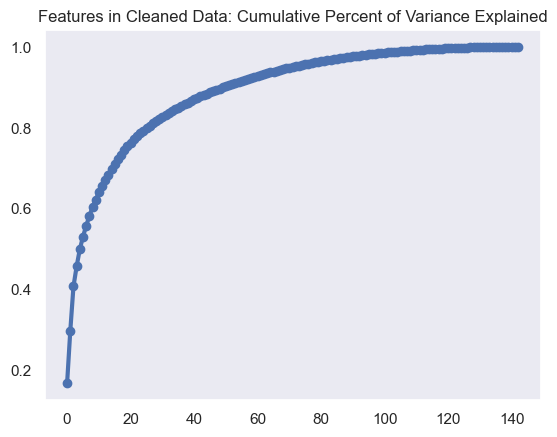

In [33]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),linewidth=3,marker='o')
plt.grid()
plt.title('Features in Cleaned Data: Cumulative Percent of Variance Explained')
plt.savefig('images/PercentVarExplained.png')
plt.show()

In [34]:
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'pca40', 'pca41', 'pca42',
       'pca43', 'pca44', 'pca45', 'pca46', 'pca47', 'pca48', 'pca49',
       'pca50', 'pca51', 'pca52', 'pca53', 'pca54', 'pca55', 'pca56',
       'pca57', 'pca58', 'pca59', 'pca60', 'pca61', 'pca62', 'pca63',
       'pca64', 'pca65', 'pca66', 'pca67', 'pca68', 'pca69', 'pca70',
       'pca71', 'pca72', 'pca73', 'pca74', 'pca75', 'pca76', 'pca77',
       'pca78', 'pca79', 'pca80', 'pca81', 'pca82', 'pca83', 'pca84',
       'pca85', 'pca86', 'pca87', 'pca88', 'pca89', 'pca90', 'pca91',
       'pca92', 'pca93', 'pca94', 'pca95', 'pca96', 'pca97', 'pca98',
       'pca99', 'pca1

In [35]:
transformer.transformers_

[('onehotencoder',
  OneHotEncoder(drop='first'),
  ['condition',
   'cylinders',
   'title_status',
   'manufacturer',
   'fuel',
   'transmission',
   'drive',
   'size',
   'type',
   'paint_color',
   'state']),
 ('remainder', StandardScaler(), [0, 1, 3])]

## DBSCAN

In [37]:
vehicles_cleansed.VIN.isnull().sum()

140882

In [38]:
print('vehicles_cleansed.shape: {}', vehicles_cleansed.shape)
vehicles_dedupe_vin = vehicles_cleansed#.drop_duplicates(subset=['VIN'], keep='first', inplace=False)
print('vehicles_dedupe_vin.shape: {}', vehicles_dedupe_vin.shape)
data = vehicles_dedupe_vin.sample(frac=0.2, replace=False, random_state=42)
print('data.shape: {}', data.shape)

vehicles_cleansed.shape: {} (360700, 16)
vehicles_dedupe_vin.shape: {} (360700, 16)
data.shape: {} (72140, 16)


Let's reduce the number of columns

In [40]:
# data_cols = [
#     'price', 'year', 'manufacturer', 'condition', 'cylinders',
#     'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
#     'size', 'type', 'paint_color'
# ]
data_cols = ['price', 'year', 'condition', 'odometer']
# data[data_cols].info()

In [41]:
data_trans = transformer.fit_transform(data[data_cols])
print('data_trans.shape: {}', data_trans.shape)

data_trans.shape: {} (72140, 9)


In [42]:
data_trans

array([[ 1.        ,  0.        ,  0.        , ..., -1.11564801,
        -1.33413612,  0.69207073],
       [ 0.        ,  1.        ,  0.        , ...,  0.06686771,
         0.74918669, -0.36470482],
       [ 0.        ,  0.        ,  0.        , ...,  0.75454373,
         0.63953812,  0.15986559],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  2.1284453 ,
         0.63953812, -0.24087042],
       [ 0.        ,  0.        ,  0.        , ...,  0.29596581,
         0.63953812, -0.26219471],
       [ 0.        ,  1.        ,  0.        , ..., -1.03930742,
        -0.23765043,  0.17290882]])

In [43]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

print('Starting DBSCAN')
start_time = time.time()

db = DBSCAN(eps=1.0, min_samples=10).fit(data_trans)
labels = db.labels_

print('Execution time: {:.2f} seconds'.format(time.time() - start_time))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Starting DBSCAN
Execution time: 94.64 seconds
Estimated number of clusters: 4
Estimated number of noise points: 176


In [44]:
labels, indices, counts = np.unique(db.labels_, return_index=True, return_counts=True)
labels, indices, counts

(array([-1,  0,  1,  2,  3]),
 array([  34,    0,  316, 1171, 1668]),
 array([  176, 71837,    15,    23,    89]))

In [45]:
data['cluster'] = db.labels_

In [46]:
data.cluster.value_counts()

cluster
 0    71837
-1      176
 3       89
 2       23
 1       15
Name: count, dtype: int64

In [47]:
data.condition.value_counts()

condition
good         22948
excellent    16809
like new      3736
fair          1166
new            186
salvage        100
Name: count, dtype: int64

In [48]:
data.query('manufacturer == "ford"').groupby(data.cluster)[['cluster']].value_counts()

cluster  cluster
-1       -1            62
 0        0         12350
 1        1             5
 2        2             7
 3        3            11
Name: count, dtype: int64

In [49]:
data.query('cluster == 0')

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,cluster
152707,indianapolis,3500,1999,lincoln,fair,6 cylinders,gas,254000,clean,automatic,NaN,rwd,NaN,NaN,white,in,0
357124,memphis,18990,2018,mazda,good,NaN,gas,18553,clean,other,3MZBN1V35JM256052,fwd,NaN,sedan,white,tn,0
300032,lima / findlay,27998,2017,ford,excellent,NaN,gas,135426,clean,automatic,1FTFW1EG0HFB55080,4wd,NaN,pickup,white,oh,0
384419,waco,23980,2019,hyundai,NaN,4 cylinders,gas,23636,clean,automatic,NaN,fwd,mid-size,SUV,custom,tx,0
76118,denver,28990,2017,lincoln,good,6 cylinders,gas,33327,clean,other,1LN6L9PK1H5634652,fwd,NaN,sedan,white,co,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367097,college station,33990,2011,chevrolet,good,8 cylinders,gas,70976,clean,other,1G1YW3DW5B5111532,rwd,NaN,other,yellow,tx,0
263228,santa fe / taos,16950,2010,mercedes-benz,excellent,6 cylinders,gas,49956,clean,automatic,WDDHF8HB7AA099312,4wd,mid-size,sedan,custom,nm,0
275038,new york city,45995,2017,mercedes-benz,NaN,NaN,gas,46143,clean,automatic,WDDZF6EBXHA193739,NaN,NaN,sedan,white,ny,0
316643,eugene,21991,2017,subaru,NaN,NaN,gas,41392,clean,manual,NaN,NaN,NaN,sedan,grey,or,0


# Regression Models

#### Train/Test datasets for modeling

In [52]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [53]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


In [54]:
# removed cols: region, VIN
data_cols=['price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive',
       'size', 'type', 'paint_color', 'state']

In [55]:
data = vehicles_cleansed[data_cols].copy()
data.head(2)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27,33590,2014,gmc,good,8 cylinders,gas,57923,clean,other,NaN,NaN,pickup,white,al
28,22590,2010,chevrolet,good,8 cylinders,gas,71229,clean,other,NaN,NaN,pickup,blue,al


In [56]:
# remove nulls for the PCA analysis
data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type', 'paint_color'], axis='index', inplace=True)
data.shape

(76137, 14)

In [57]:
data.to_csv('data/samples.csv')

In [58]:
# data_trans = transformer.fit_transform(data)
# print('data_trans.shape: {}', data_trans.shape)

In [59]:
X = data.drop('price', axis='columns')
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### LinearRegression

In [61]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso()
]

In [62]:
fit_time = 0
for model in models:
    clf = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])
    model_name = clf.get_params()['model'].__class__.__name__
    print("Working on {} ... ".format(model_name), end='')
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    mse = mean_squared_error(preds, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(preds, y_test)
    score = clf.score(X_test, y_test)
    # fit_time = clf.cv_results_['mean_fit_time']
    
    print('Done')
    print('{}: MSE: {:,.4f}, RMSE: {:,.4f}, R2: {:,.4f}, Score: {:,.4f}, fit_time: {:,.4f}'
          .format(model_name, mse, rmse, r2, score, fit_time))

Working on LinearRegression ... Done
LinearRegression: MSE: 65,046,230.4471, RMSE: 8,065.1243, R2: -0.1746, Score: 0.4594, fit_time: 0.0000
Working on Ridge ... Done
Ridge: MSE: 64,994,791.3063, RMSE: 8,061.9347, R2: -0.1778, Score: 0.4598, fit_time: 0.0000
Working on Lasso ... Done
Lasso: MSE: 65,104,206.5810, RMSE: 8,068.7178, R2: -0.1952, Score: 0.4589, fit_time: 0.0000


In [63]:
clf.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder=StandardScaler(),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x12a9c9a90>)])),
  ('model', Lasso())],
 'verbose': False,
 'transformer': ColumnTransformer(remainder=StandardScaler(),
                   transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12a9c9a90>)]),
 'model': Lasso(),
 'transformer__force_int_remainder_cols': True,
 'transformer__n_jobs': None,
 'transformer__remainder__copy': True,
 'transformer__remainder__with_mean': True,
 'transformer__remainder__with_std': True,
 'transformer__remainder': StandardScaler(),
 'transformer__sparse_threshold': 0.3,
 'transformer__transformer_weights': None,
 'transformer__transformers': [('onehotencoder',
 

# Final Modeling

## Data Cleaning

In [66]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.12202787399291992
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model']
... mod_zscore
... id
... model
Done: (360700, 19) -> (360700, 16)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformations:
... Conver

In [67]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  VIN           219818 non-null  object  
 11  drive         252582 non-null  category
 12  size          104338 non-null  category
 13  type          282300 non-null  category
 14  paint_color   257706 non-null  category
 15  state         360700 non-null  category
dtypes: category(11), int64(3), object(2)
memory usage: 20.3+ MB


In [68]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [69]:
# removed cols: 'region', 'manufacturer', 'VIN', 'paint_color', 'state'
drop_cols = ['region', 'manufacturer', 'VIN', 'paint_color', 'state']
features=['year', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 
          'transmission', 'drive', 'size', 'type']

In [70]:
# Create a copy of the clean data and remove unwanted columnss
data = vehicles_cleansed.copy()
data.drop(columns=drop_cols, inplace=True)

In [71]:
# remove nulls before splitting data
print('Dropping nulls: {} -> '.format(data.shape), end='')
data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type'], axis='index', inplace=True)
print(' {}'.format(data.shape))

Dropping nulls: (360700, 11) ->  (78626, 11)


In [72]:
data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'size', 'type'],
      dtype='object')

## Create Train/Test splits

In [74]:
X = data[features]
y = data['price']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78626 entries, 31 to 426833
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          78626 non-null  int64   
 1   condition     78626 non-null  category
 2   cylinders     78626 non-null  category
 3   fuel          78626 non-null  category
 4   odometer      78626 non-null  int64   
 5   title_status  78626 non-null  category
 6   transmission  78626 non-null  category
 7   drive         78626 non-null  category
 8   size          78626 non-null  category
 9   type          78626 non-null  category
dtypes: category(8), int64(2)
memory usage: 2.4 MB


## Data Preparation for Modeling

In [78]:
selector = make_column_selector(dtype_include=['object', 'category'])
data.select_dtypes(include=['object', 'category']).columns

Index(['condition', 'cylinders', 'fuel', 'title_status', 'transmission',
       'drive', 'size', 'type'],
      dtype='object')

In [79]:
# Preprocess the data
# One-hot encode the 'condition' categorical features
# Scale numeric features
transformer = make_column_transformer(
    (OneHotEncoder(drop = 'first'), selector),
    remainder= StandardScaler()
)
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x12b267350>)])

## Baseline Regression Models

In [81]:
models = [
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.1)
]

In [82]:
# Evaluate models
def get_model_metrics_as_results(clf_pipe, X_train, y_train, X_test, y_test):
    """
    Build standardized results tabel given the classifire pipeline handle and train/test splits

    :param clf_pipe: Classifier pipeline with named 'model' and 'transformer' stages. Will call fit() and predict() to generate metrics
    :param X_train: Training X
    :param y_train: Training y
    :param X_test: Test X
    :param y_test: Test y
    :return: Returns single row of results summary table containing:
    
        [model_name, MAE, MSE, RMSE, R2_Score]
    """

    start_time = time.time()

    model_name = clf_pipe.get_params()['model'].__class__.__name__
    logging.debug(f'Working on {model_name}')

    # Call fit, predict
    clf_pipe.fit(X_train, y_train)
    y_preds = clf_pipe.predict(X_test)

    # get metrics
    mae = mean_absolute_error(y_preds, y_test)
    mse = mean_squared_error(y_preds, y_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_preds, y_test)
    score = clf_pipe.score(X_test, y_test)
    # time = clf_pipe.cv_results_['mean_fit_time']

    lapse = time.time() - start_time
    
    logging.debug(f'... {model_name}: MAE: {mae:,.4f}, MSE: {mse:,.4f}, RMSE: {rmse:,.4f}, R2: {r2:,.4f}, Score: {score:,.4f}, time: {lapse:,.4f}')

    return [model_name, mae, mse, rmse, score]

In [83]:
logging.getLogger().setLevel(logging.DEBUG)

results_baseline = []

# iterate over the models and build results DF
for model in models:
    clf = Pipeline([
        ('transformer', transformer),
        ('model', model)
    ])

    results_baseline.append(get_model_metrics_as_results(clf, X_train, y_train, X_test, y_test))

logging.getLogger().setLevel(logging.INFO)

DEBUG: Working on LinearRegression
DEBUG: ... LinearRegression: MAE: 5,946.1381, MSE: 68,680,449.6276, RMSE: 8,287.3669, R2: -0.2866, Score: 0.4277, time: 0.3489
DEBUG: Working on Ridge
DEBUG: ... Ridge: MAE: 5,946.0982, MSE: 68,679,488.7110, RMSE: 8,287.3089, R2: -0.2871, Score: 0.4277, time: 0.3753
DEBUG: Working on Lasso
DEBUG: ... Lasso: MAE: 5,946.1342, MSE: 68,680,502.5796, RMSE: 8,287.3701, R2: -0.2872, Score: 0.4277, time: 1.7237


In [84]:
results_baseline_df = pd.DataFrame(results_baseline, 
                                   columns=['Model','MAE', 'MSE', 'RMSE', 'Score']
                                  ).set_index('Model')
results_baseline_df.style.format('{:,.4f}')

,MAE,MSE,RMSE,Score
Model,,,,
LinearRegression,"5,946.1381","68,680,449.6276","8,287.3669",0.4277
Ridge,"5,946.0982","68,679,488.7110","8,287.3089",0.4277
Lasso,"5,946.1342","68,680,502.5796","8,287.3701",0.4277


In [85]:
import dataframe_image as dfi

dfi.export(results_baseline_df.style.format('{:,.2f}'), 'images/results_baseline_table.png')